In [24]:
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 

transform = transforms.Compose( [ transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  
#the normalize tool maps image values from [0,1] to [-1, 1] which is standard for deep learning models 
#Compose combines multiple image transformstions sequentially 
#ToTensor converts PIL image values (0-255) to pytorch tensors(0-1)
#Normalize normalizes each rgb channel where mean=0.5 and std=0.5 (pixel = (pixel-mean)/std). now it maps the pixel values from [0,1] to [-1,1]


In [25]:
train_transform = transforms.Compose( [ transforms.RandomResizedCrop(256, scale = (0.9, 1.0)), transforms.RandomRotation(15), 
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1), 
                                       transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ] )

In [26]:
val_transform = transforms.Compose( [ transforms.Resize((256, 256)), transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [27]:
train_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\train', transform=train_transform) 
test_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\test', transform=transform) 
val_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\valid', transform=val_transform) 
#loading the training, test and validation data using imagefolder 

In [28]:
train_loader = DataLoader(train_data, batch_size=50, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=50, shuffle=False) 
val_loader = DataLoader(val_data, batch_size=50, shuffle=False) 
#creating data loaders to load images in batches of 50

print(train_data.classes) 

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [29]:
import matplotlib.pyplot as plt 
import numpy as np 
import torchvision 

def imshow(img):                                                        #function to unnormalize and display images
    img = img/2 + 0.5                                                   #unnormalizes the images and converts the tensors from [-1,1] to [0,1]
    npimg = img.numpy()                                                 #converts tensors to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))                          #transpose swaps axises from (C,H,W) to (H,W,C)
    plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


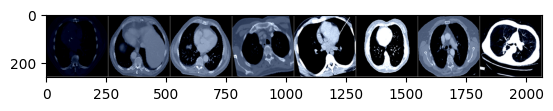

Labels:  ['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'normal', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']


In [30]:
dataiter = iter(train_loader)                                           #creates an iterator for training images
images, labels = next(dataiter)                                         #gets a batch of images and labels

imshow(torchvision.utils.make_grid(images[:8]))                             #combines multiple images into a single grid (8) and displays them
print('Labels: ', [train_data.classes[i] for i in labels[:8]])                    #prints image labels of the 8 images

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class cancer_pred_cnn(nn.Module):
    def __init__(self, num_classes=4):
        super(cancer_pred_cnn, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [32]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = cancer_pred_cnn(num_classes=4).to(device)  

class_weights = torch.tensor([2.625, 6.176, 5.833, 3.500])

criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)

In [33]:
class EarlyStopping: 
    def __init__(self, patience = 4, min_delta = 0.0005): 
        self.patience = patience 
        self.min_delta = min_delta 
        self.counter = 0 
        self.best_loss = None 
        self.early_stop = False 
    
    def __call__(self, val_loss): 
        if self.best_loss is None: 
            self.best_loss = val_loss 
        elif val_loss > self.best_loss - self.min_delta: 
            self.counter += 1 
            if self.counter >= self.patience: 
                self.early_stop = True 
        else: 
            self.best_loss = val_loss 
            self.counter = 0

In [34]:
num_epochs = 20
for epoch in range(num_epochs):                                                           #training loop
    model.train() 
    running_loss = 0.0 
    total = 0.0                                                                           #total no of images going through the model
    correct = 0.0                                                                         #no of images correctly predicted
    
    for images, labels in train_loader:                                                   #loop to load the data batchwise 
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()                                                             
        outputs = model(images)                                                           
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()                                                       #converts loss from tensor to float 
        total += labels.size(0)                                                           #adds no of images in batch to total
        _, predicted = torch.max(outputs.data, 1)                                         #returns index of class with highest scores instead of a tuple
        correct += (predicted == labels).sum().item()                                     #counts no of correct predictions

    train_loss = running_loss / len(train_loader)                                         #avg epoch loss
    train_acc = 100*correct/total                                                         
    



    model.eval() 
    val_correct=0.0 
    val_total=0.0 
    val_loss=0.0 

    with torch.no_grad(): 
        for images, labels in val_loader: 
            images, labels = images.to(device), labels.to(device) 
            outputs=model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item() 
            _, predicted = outputs.max(1) 
            val_total += labels.size(0) 
            val_correct += predicted.eq(labels).sum().item() 

    val_acc = 100*val_correct/val_total 
    val_loss /= len(val_loader) 
    scheduler.step(val_loss)

    print(f"Epoch: [{epoch+1}/{num_epochs}]     training loss: {train_loss:.4f}     training accuracy: {train_acc:.2f}%     validation loss: {val_loss:.4f}     validation accuracy: {val_acc:.2f}%") 

    early_stopping = EarlyStopping(patience=4, min_delta=0.0005)
    early_stopping(val_loss) 
    if early_stopping.early_stop: 
        print("Early stopping trigegered, training stopped") 
        break 


Epoch: [1/20]     training loss: 0.9813     training accuracy: 47.47%     validation loss: 1.6291     validation accuracy: 20.83%
Epoch: [2/20]     training loss: 0.8668     training accuracy: 55.95%     validation loss: 1.7542     validation accuracy: 20.83%
Epoch: [3/20]     training loss: 0.8656     training accuracy: 53.67%     validation loss: 1.9659     validation accuracy: 23.61%
Epoch: [4/20]     training loss: 0.7809     training accuracy: 60.20%     validation loss: 0.7502     validation accuracy: 59.72%
Epoch: [5/20]     training loss: 0.7272     training accuracy: 62.81%     validation loss: 0.8249     validation accuracy: 47.22%
Epoch: [6/20]     training loss: 0.7046     training accuracy: 63.13%     validation loss: 0.9688     validation accuracy: 50.00%
Epoch: [7/20]     training loss: 0.7006     training accuracy: 66.88%     validation loss: 0.8335     validation accuracy: 63.89%
Epoch: [8/20]     training loss: 0.6802     training accuracy: 67.37%     validation loss: